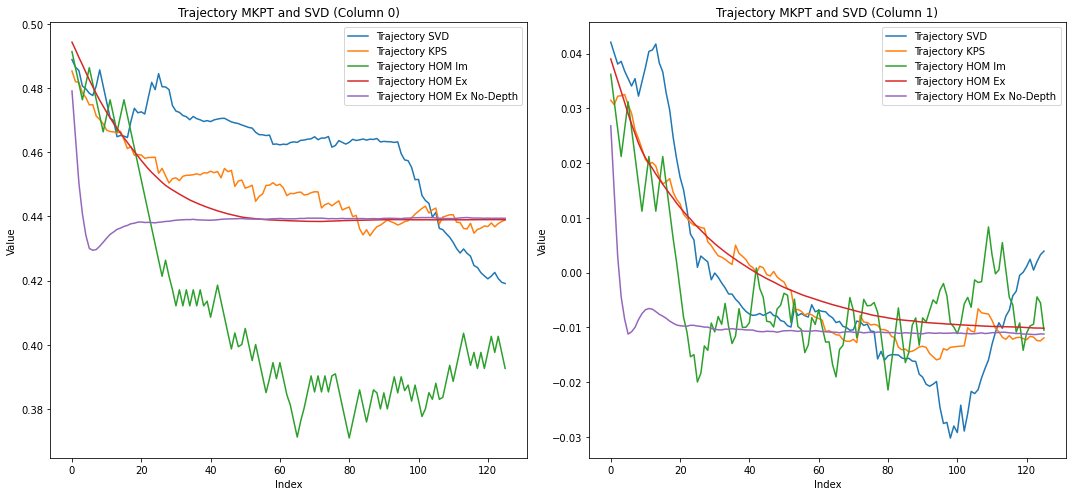

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
traj_kps_0 = np.load("trajectory_kps.npy")[:, 0]
traj_kps_sp_lg_0 = np.load("trajectory_kps_sp+lg.npy")[:, 0]
traj_svd_0 = np.load("trajectory_svd.npy")[:, 0]
traj_hom_i_0 = np.load("trajectory_hom_implicit.npy")[:, 0]
traj_hom_e_0 = np.load("trajectory_hom.npy")[:, 0]
traj_hom_no_depth_0 = np.load("trajectory_hom_no_depth.npy")[:, 0]

traj_kps_1 = np.load("trajectory_kps.npy")[:, 1]
traj_kps_sp_lg_1 = np.load("trajectory_kps_sp+lg.npy")[:, 1]
traj_svd_1 = np.load("trajectory_svd.npy")[:, 1]
traj_hom_i_1 = np.load("trajectory_hom_implicit.npy")[:, 1]
traj_hom_e_1 = np.load("trajectory_hom.npy")[:, 1]
traj_hom_no_depth_1 = np.load("trajectory_hom_no_depth.npy")[:, 1]

# Generate an x-axis
x = np.arange(len(traj_kps_0))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot the first set of data
axs[0].plot(x, traj_svd_0, label='Trajectory SVD')
axs[0].plot(x, traj_kps_0, label='Trajectory KPS')
axs[0].plot(x, traj_hom_i_0, label='Trajectory HOM Im')
axs[0].plot(x, traj_hom_e_0, label='Trajectory HOM Ex')
axs[0].plot(x, traj_hom_no_depth_0, label='Trajectory HOM Ex No-Depth')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Trajectory MKPT and SVD (Column 0)')
axs[0].legend()

# Plot the second set of data
axs[1].plot(x, traj_svd_1, label='Trajectory SVD')
axs[1].plot(x, traj_kps_1, label='Trajectory KPS')
axs[1].plot(x, traj_hom_i_1, label='Trajectory HOM Im')
axs[1].plot(x, traj_hom_e_1, label='Trajectory HOM Ex')
axs[1].plot(x, traj_hom_no_depth_1, label='Trajectory HOM Ex No-Depth')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Trajectory MKPT and SVD (Column 1)')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


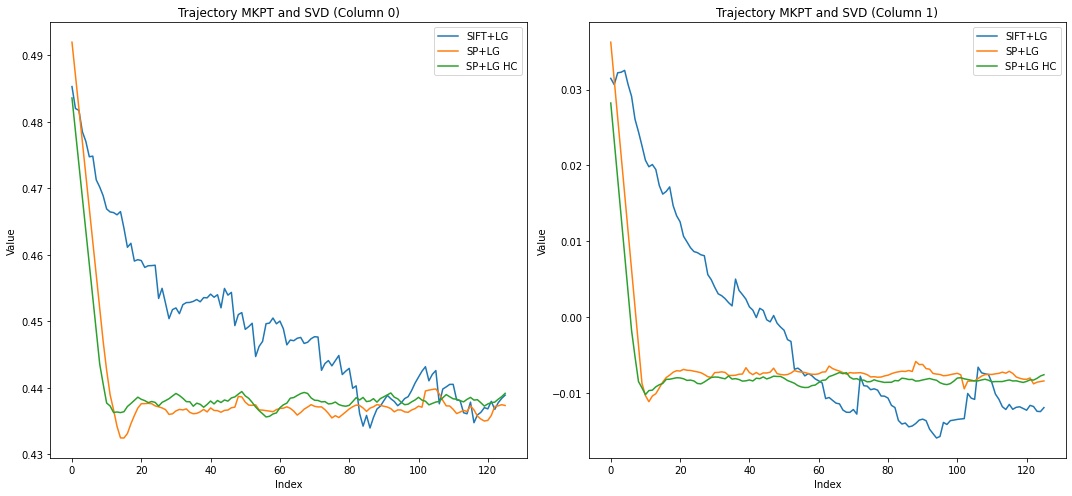

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
traj_kps_0 = np.load("trajectory_kps.npy")[:, 0]
traj_kps_sp_lg_0 = np.load("trajectory_kps_sp+lg.npy")[:, 0]
traj_kps_sp_lg_hc_0 = np.load("trajectory_kps_highest_confidence.npy")[:, 0]

traj_kps_1 = np.load("trajectory_kps.npy")[:, 1]
traj_kps_sp_lg_1 = np.load("trajectory_kps_sp+lg.npy")[:, 1]
traj_kps_sp_lg_hc_1 = np.load("trajectory_kps_highest_confidence.npy")[:, 1]
# Generate an x-axis
x = np.arange(len(traj_kps_0))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot the first set of data
axs[0].plot(x, traj_kps_0, label='SIFT+LG')
axs[0].plot(x, traj_kps_sp_lg_0, label='SP+LG')
axs[0].plot(x, traj_kps_sp_lg_hc_0, label='SP+LG HC')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].set_title('Trajectory MKPT and SVD (Column 0)')
axs[0].legend()

# Plot the second set of data
axs[1].plot(x, traj_kps_1, label='SIFT+LG')
axs[1].plot(x, traj_kps_sp_lg_1, label='SP+LG')
axs[1].plot(x, traj_kps_sp_lg_hc_1, label='SP+LG HC')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].set_title('Trajectory MKPT and SVD (Column 1)')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [131]:
# Number of files to load
num_files = 9  # Adjust this number as needed

# Load and stack the .npy files
trajectories = np.stack([np.load(f"sharpener_no_filter{i}.npy") for i in range(num_files)])
trajectories = np.stack([np.load(f"sharpener_no_filter{i}.npy") for i in range(7, 9)])

In [152]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Current End-Effector Pose
current_position = np.array([0.5431232113600617, 0.09831868740204831, 0.4817080225602446])
current_orientation = np.array([0.9497657726740287, -0.30805504904622943, 0.05431180346290895, 0.009863661522838933])

# Reference End-Effector Pose
ref_position = np.array([0.5041812568964179, 0.09185436015924689, 0.48143709451847916])
ref_orientation = np.array([-0.9983786626178943, 0.013449729176136651, -0.054892707858185244, 0.006778011389003352])

# Compute the translation difference (position delta)
translation_delta = current_position - ref_position

# Compute the rotation difference (orientation delta)
# Convert quaternions to rotation matrices
current_rot_matrix = R.from_quat(current_orientation).as_matrix()
ref_rot_matrix = R.from_quat(ref_orientation).as_matrix()

# Compute the relative rotation matrix
rotation_delta_matrix = current_rot_matrix @ ref_rot_matrix.T

# Convert the rotation matrix back to a quaternion
rotation_delta = R.from_matrix(rotation_delta_matrix).as_quat()

# Combine translation and rotation into a transformation
transformation = np.concatenate([translation_delta, rotation_delta])
transformation


array([ 3.89419545e-02,  6.46432724e-03,  2.70928042e-04, -1.05695660e-04,
        1.32133594e-04, -2.95691065e-01,  9.55283605e-01])

In [ ]:
[[ 0.81135922  0.5761315   0.09883681  0.0600903 ]
 [-0.57745375  0.81623445 -0.01756387  0.3153969 ]
 [-0.0907931  -0.04282308  0.99494864  0.04048643]
 [ 0.          0.          0.          1.        ]]


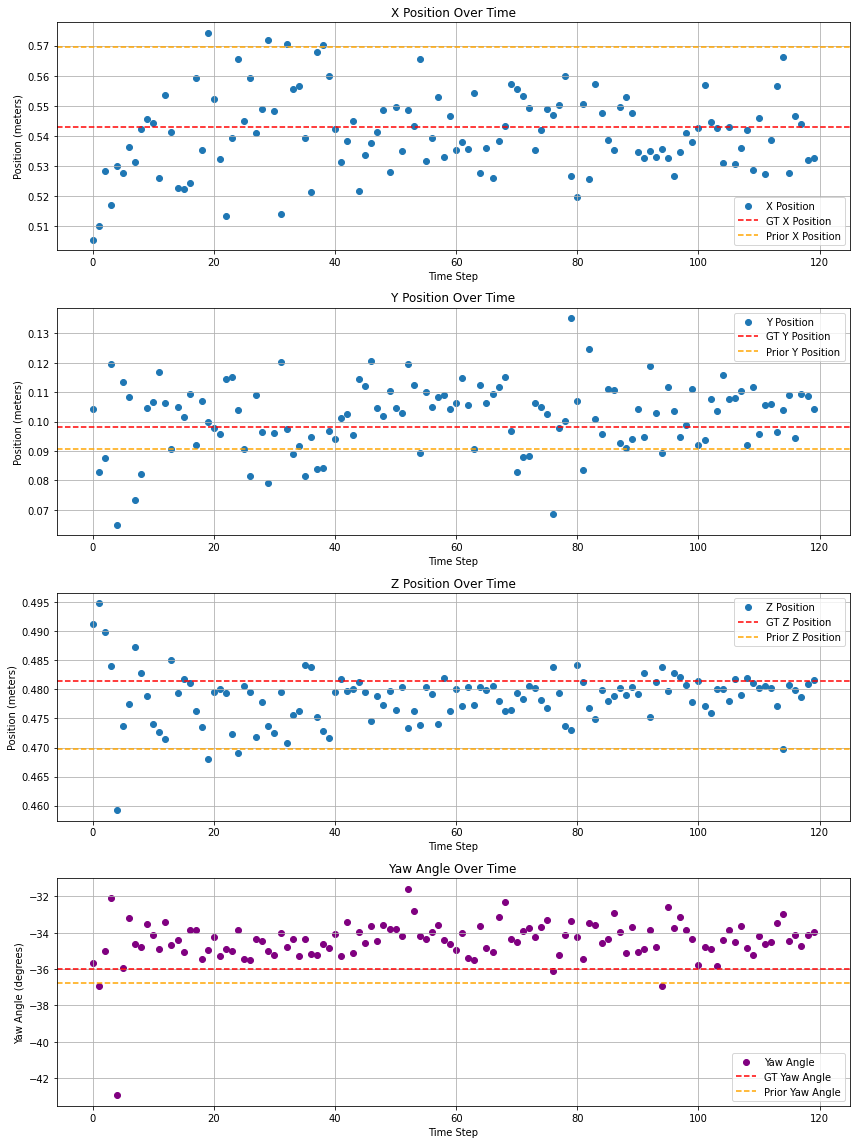

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from trajectory_utils import create_homogeneous_matrix
# Load the states from the saved file
states = np.load("states_no_filter1.npy")

# Reference End-Effector Pose
ref_position = np.array([0.5041812568964179, 0.09185436015924689, 0.48143709451847916])
ref_orientation = np.array([-0.9983786626178943, 0.013449729176136651, -0.054892707858185244, 0.006778011389003352])

# Extract positions and yaw angle (assuming the last element is yaw)
x_positions = states[:, 0]
y_positions = states[:, 1]
z_positions = states[:, 2]
yaw_angles = np.rad2deg(states[:, -1])  # Convert yaw from radians to degrees

# Create time axis based on the number of states
time_axis = np.arange(states.shape[0])

# Ground truth data
gt_position = np.array([0.5431232113600617, 0.09831868740204831, 0.48143709451847916])
gt_orientation = np.array([0.9497657726740287, -0.30805504904622943, 0.05431180346290895, 0.009863661522838933])
gt_yaw_angle = np.rad2deg(np.arctan2(2*(gt_orientation[0]*gt_orientation[1] + gt_orientation[2]*gt_orientation[3]),
                                      1 - 2*(gt_orientation[1]**2 + gt_orientation[2]**2)))

# Prior data (transformation matrix)
prior_transform = np.array([[ 0.81135922,  0.5761315,   0.09883681,  0.0600903 ],
                            [-0.57745375,  0.81623445, -0.01756387,  0.3153969 ],
                            [-0.0907931,  -0.04282308,  0.99494864,  0.04048643],
                            [ 0.,          0.,          0.,          1.        ]])

prior_transform = prior_transform @ create_homogeneous_matrix(ref_position,  ref_orientation)

# Extract position from prior transformation matrix
prior_position = prior_transform[:3, 3]

# Convert rotation matrix from prior to yaw angle (assuming simple arctan2 method)
prior_yaw_angle = np.rad2deg(np.arctan2(prior_transform[1, 0], prior_transform[0, 0]))

# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 16))

# Plot X Position
ax[0].scatter(time_axis, x_positions, label='X Position', marker='o')
ax[0].axhline(gt_position[0], color='red', linestyle='--', label='GT X Position')
ax[0].axhline(prior_position[0], color='orange', linestyle='--', label='Prior X Position')
ax[0].set_title('X Position Over Time')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Position (meters)')
ax[0].legend()
ax[0].grid(True)

# Plot Y Position
ax[1].scatter(time_axis, y_positions, label='Y Position', marker='o')
ax[1].axhline(gt_position[1], color='red', linestyle='--', label='GT Y Position')
ax[1].axhline(prior_position[1], color='orange', linestyle='--', label='Prior Y Position')
ax[1].set_title('Y Position Over Time')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Position (meters)')
ax[1].legend()
ax[1].grid(True)

# Plot Z Position
ax[2].scatter(time_axis, z_positions, label='Z Position', marker='o')
ax[2].axhline(gt_position[2], color='red', linestyle='--', label='GT Z Position')
ax[2].axhline(prior_position[2], color='orange', linestyle='--', label='Prior Z Position')
ax[2].set_title('Z Position Over Time')
ax[2].set_xlabel('Time Step')
ax[2].set_ylabel('Position (meters)')
ax[2].legend()
ax[2].grid(True)

# Plot Yaw Angle
ax[3].scatter(time_axis, yaw_angles, label='Yaw Angle', color='purple', marker='o')
ax[3].axhline(gt_yaw_angle, color='red', linestyle='--', label='GT Yaw Angle')
ax[3].axhline(prior_yaw_angle, color='orange', linestyle='--', label='Prior Yaw Angle')
ax[3].set_title('Yaw Angle Over Time')
ax[3].set_xlabel('Time Step')
ax[3].set_ylabel('Yaw Angle (degrees)')
ax[3].legend()
ax[3].grid(True)

plt.tight_layout()
plt.show()




In [127]:
np.save("sharpener_no_filters.npy", np.array(trajectories))

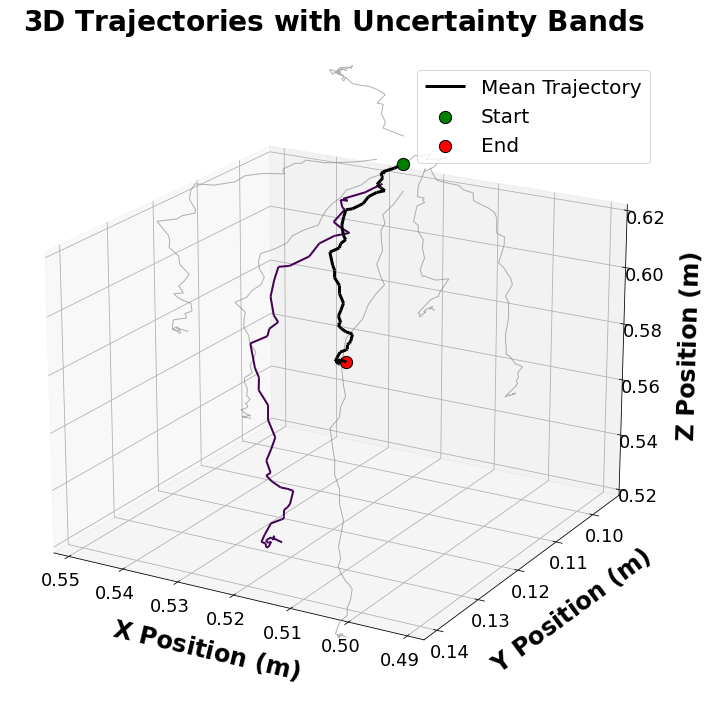

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Compute the mean and standard deviation across all trajectories for each point
mean_trajectory = np.mean(trajectories, axis=0)
std_trajectory = np.std(trajectories, axis=0)

# Extract mean components
mean_x = mean_trajectory[:, 0]
mean_y = mean_trajectory[:, 1]
mean_z = mean_trajectory[:, 2]
mean_yaw = mean_trajectory[:, 3]

# Extract standard deviation components
std_x = std_trajectory[:, 0]
std_y = std_trajectory[:, 1]
std_z = std_trajectory[:, 2]

# Large plot for better visibility
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Color map for multiple trajectories
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, trajectories.shape[0]))  # Different color for each trajectory

# Plot individual trajectories
for i, trajectory in enumerate(trajectories):
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    z = trajectory[:, 2]
    yaw = trajectory[:, 3]

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, color=colors[i], linewidth=2)
    ax.add_collection3d(lc)

# Plot mean trajectory
points_mean = np.array([mean_x, mean_y, mean_z]).T.reshape(-1, 1, 3)
segments_mean = np.concatenate([points_mean[:-1], points_mean[1:]], axis=1)
lc_mean = Line3DCollection(segments_mean, color='black', linewidth=3, label='Mean Trajectory')
ax.add_collection3d(lc_mean)

# Plot uncertainty bands as lines (Mean ± 1 Standard Deviation)
ax.plot(mean_x + std_x, mean_y, mean_z, color='gray', alpha=0.6, linewidth=1)
ax.plot(mean_x - std_x, mean_y, mean_z, color='gray', alpha=0.6, linewidth=1)
ax.plot(mean_x, mean_y + std_y, mean_z, color='gray', alpha=0.6, linewidth=1)
ax.plot(mean_x, mean_y - std_y, mean_z, color='gray', alpha=0.6, linewidth=1)
ax.plot(mean_x, mean_y, mean_z + std_z, color='gray', alpha=0.6, linewidth=1)
ax.plot(mean_x, mean_y, mean_z - std_z, color='gray', alpha=0.6, linewidth=1)

# Scatter the start and end points of the mean trajectory
ax.scatter(mean_x[0], mean_y[0], mean_z[0], color='green', s=150, edgecolors='black', label='Start')
ax.scatter(mean_x[-1], mean_y[-1], mean_z[-1], color='red', s=150, edgecolors='black', label='End')

# Labels and title with larger fonts
ax.set_xlabel(r'$\mathbf{X\ Position\ (m)}$', fontsize=24, labelpad=20)
ax.set_ylabel(r'$\mathbf{Y\ Position\ (m)}$', fontsize=24, labelpad=20)
ax.set_zlabel(r'$\mathbf{Z\ Position\ (m)}$', fontsize=24, labelpad=20)
ax.set_title(r'$\mathbf{3D\ Trajectories\ with\ Uncertainty\ Bands}$', fontsize=28, pad=30)

# Setting the limits for clarity (adjust as needed)
ax.set_xlim(np.min(trajectories[:, :, 0]), np.max(trajectories[:, :, 0]))
ax.set_ylim(np.min(trajectories[:, :, 1]), np.max(trajectories[:, :, 1]))
ax.set_zlim(0.52, 0.62)

# Set the viewing angle
ax.view_init(elev=20, azim=120)

# Add legend with larger fonts
ax.legend(loc='upper right', fontsize=20)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='z', which='major', labelsize=18)

# Show plot
plt.show()

In [37]:
from scipy.spatial.transform import Rotation as R
import json
import numpy as np

def create_homogeneous_matrix(xyz, quaternion):
    rotation_matrix = R.from_quat(quaternion).as_matrix()
    T = np.eye(4) 
    T[:3, :3] = rotation_matrix
    T[:3, 3] = xyz 

    return T

def pose_inv(pose):
    R = pose[:3, :3]
    T = np.eye(4)
    T[:3, :3] = R.T
    T[:3, 3] = - R.T @ np.ascontiguousarray(pose[:3, 3])
    return T


K = np.load("handeye/intrinsics_d415.npy")
T_WC = np.load("handeye/T_WC_head.npy")
DIR = "scissor"

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

array([[ 0.50418126,  0.09185436,  0.48143709, -0.99837866,  0.01344973,
        -0.05489271,  0.00677801],
       [ 0.49467759, -0.13398116,  0.37963961, -0.99430351,  0.0169949 ,
         0.01044858,  0.10470206],
       [ 0.45931572,  0.06573993,  0.28584844,  0.99737963,  0.05747579,
         0.03869391,  0.02081296],
       [ 0.49295565, -0.11312451,  0.28185395, -0.99430351,  0.0169949 ,
         0.01044858,  0.10470206],
       [ 0.45931572,  0.15073993,  0.28584844,  0.99737963,  0.05747579,
         0.03869391,  0.02081296]])

In [7]:
with open(f"experiments/{DIR}/rearrange.json") as f:
    dbn = json.load(f)
    rearrange_waypopints = np.vstack([dbn[key] for key in dbn.keys()])
from trajectory_utils import apply_transformation_to_waypoints
live_waypoints = apply_transformation_to_waypoints(rearrange_waypopints, np.eye(4), project3D=True)
rearrange_waypopints[0].tolist(), live_waypoints[0]

([0.45931572361010736,
  0.0123992983923882,
  0.2828484408140383,
  0.9973796349171662,
  0.05747578692881908,
  0.0386939072948877,
  0.020812960089042848],
 [0.45931572361010736,
  0.0123992983923882,
  0.2828484408140383,
  0.9973796349171661,
  0.05747578692881907,
  0.0386939072948877,
  0.020812960089042844])

In [8]:
point_2Ds = []

for i in range(len(demo_waypoints)):
    point3d = pose_inv(T_WC)  @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

point_2Ds

[array([859.99596727, 289.76787131]),
 array([545.73864482, 393.58624967]),
 array([768.51169028, 480.56548162]),
 array([579.20989384, 498.19860031]),
 array([877.79304475, 481.56117934])]

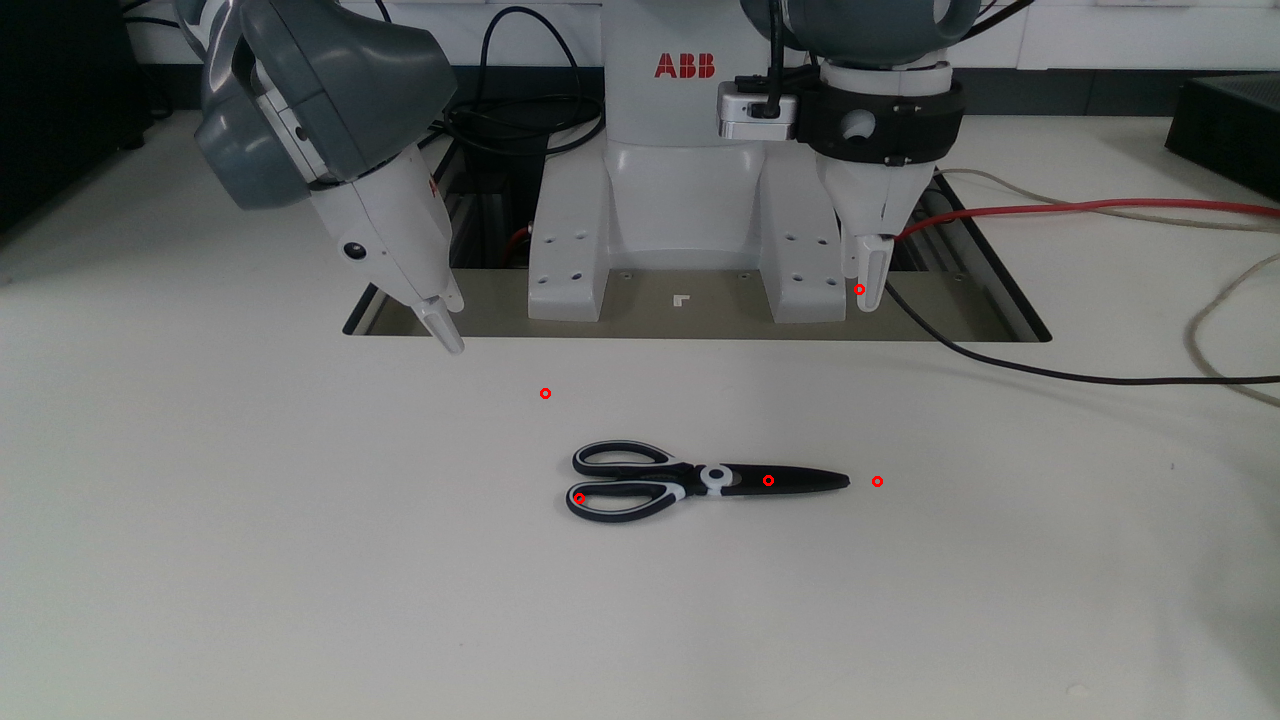

In [9]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

In [10]:
T_wrist_head = np.array( [[ 0.03747486,  0.9916625,  -0.12329277,  0.06823914],
  [-0.47062567,  0.12635414,  0.87323886, -0.10383146],
  [ 0.8815368,   0.02530024,  0.47143695,  0.2750577 ],
  [ 0.,          0.,          0.,          1.        ]]
)

T_camera_eef = np.load("handeye/T_C_EEF_wrist_l.npy")
T_eef_world = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
T_camera_world = T_camera_eef @ T_eef_world

pose_inv(T_wrist_head) @ T_camera_world

array([[ 0.01798912, -0.53521242, -0.84452594,  0.12956062],
       [-0.9744783 ,  0.17964675, -0.1346071 , -0.54092505],
       [ 0.22375974,  0.82539367, -0.51832122,  0.29417984],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [71]:
T_camera_world @ T_wrist_head 

array([[-0.17416423, -0.97694116,  0.12350217, -0.59783187],
       [-0.54135004,  0.1997571 ,  0.81672347, -0.04945908],
       [-0.82256122,  0.0753861 , -0.5636577 ,  0.23065564],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [72]:
T_WC = np.load("handeye/T_WC_head.npy")
T_WC @ pose_inv(T_wrist_head)

array([[ 0.64246282, -0.66711954, -0.37708494,  0.99931101],
       [ 0.04668669, -0.457086  ,  0.88819635, -0.33981611],
       [-0.76489337, -0.58823797, -0.26251517,  0.67683488],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [73]:
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])

pose_inv(T_GRIP_EEF)

array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   , -0.136],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [13]:

with open(f"experiments/{DIR}/demo_bottlenecks.json") as f:
    dbn = json.load(f)
    
demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])
demo_waypoints

K_wrist = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])

for i in range(len(demo_waypoints)):

    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K_wrist, point3d[:3, 3])
    print(point3d[:3, 3])
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()

[0.0082311  0.07647842 0.09797773]
[ 0.04514419 -0.11732952  0.20456844]
[0.07643522 0.05364505 0.28948751]
[ 0.05650208 -0.09147894  0.30049939]
[0.07626442 0.13853224 0.28511323]
[array([454.97064198, 571.72707746]), array([513.95274412, -12.14928997]), array([532.66375495, 315.05949138]), array([499.86090324, 103.8931002 ]), array([534.15344383, 444.66316423])]


In [84]:
import numpy as np
from scipy.optimize import minimize
import cv2

def project_points(X, K, R, t):
    """ Project 3D points X to 2D points using camera intrinsics K, rotation R, and translation t. """
    X_cam = R @ X + t
    X_cam = X_cam / X_cam[2]  # Normalize by depth
    uv = K @ X_cam
    return uv[:2]

def reprojection_error(params, X_world, uv_pixel, K):
    """ Compute the reprojection error. """
    # Extract rotation vector and translation vector from params
    rvec = params[:3]
    tvec = params[3:]

    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)

    # Project points
    uv_proj = project_points(X_world, K, R, tvec)

    # Compute error
    error = uv_proj - uv_pixel
    return np.sum(error**2)

# 3D point in world coordinates (example values)
X_world = demo_waypoints[0, :3]

# Corresponding pixel coordinates in image
uv_pixel = np.array([652, 287])

# Initial guess for rotation (rvec) and translation (tvec)
initial_guess = np.zeros(6)

# Perform optimization to minimize the reprojection error
result = minimize(reprojection_error, initial_guess, args=(X_world, uv_pixel, K), method='BFGS')

# Extract optimized rotation and translation
rvec_optimized = result.x[:3]
tvec_optimized = result.x[3:]

# Convert optimized rotation vector to matrix
R_optimized, _ = cv2.Rodrigues(rvec_optimized)

print("Optimized Rotation Matrix:\n", R_optimized)
print("Optimized Translation Vector:\n", tvec_optimized)

point_2Ds = [[652, 287]]
for i in range(len(demo_waypoints)):
    R, _ = cv2.Rodrigues(rvec_optimized)
    uv_proj = project_points(X_world, K, R, tvec_optimized)

    point_2Ds.append(point_2D)
    break

wrist_rgb = Image.open(f"experiments/{DIR}/demo_wrist_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)

print(point_2Ds)
# Save or show the image
wrist_rgb.show()


Optimized Rotation Matrix:
 [[ 0.54561887  0.15026126  0.82445231]
 [-0.11720431  0.98780736 -0.10246839]
 [-0.82979709 -0.04072068  0.5565776 ]]
Optimized Translation Vector:
 [-0.64044619 -0.07871545  2.06754796]
[[652, 287], array([626.82528941, 404.76565406])]


In [196]:
create_homogeneous_matrix([0.58381608, -0.00932566, 0.3015399], [0, 0, 0, 1])


array([[ 1.        ,  0.        ,  0.        ,  0.58381608],
       [ 0.        ,  1.        ,  0.        , -0.00932566],
       [ 0.        ,  0.        ,  1.        ,  0.3015399 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

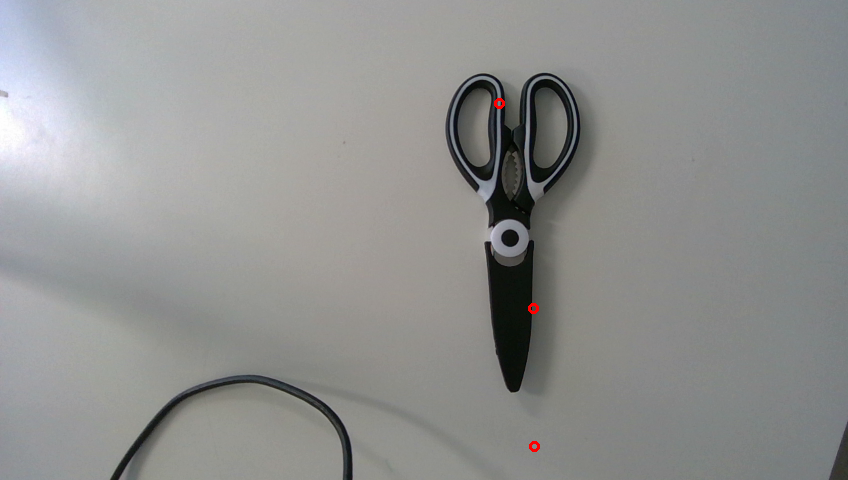

In [189]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_d405_rgb.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

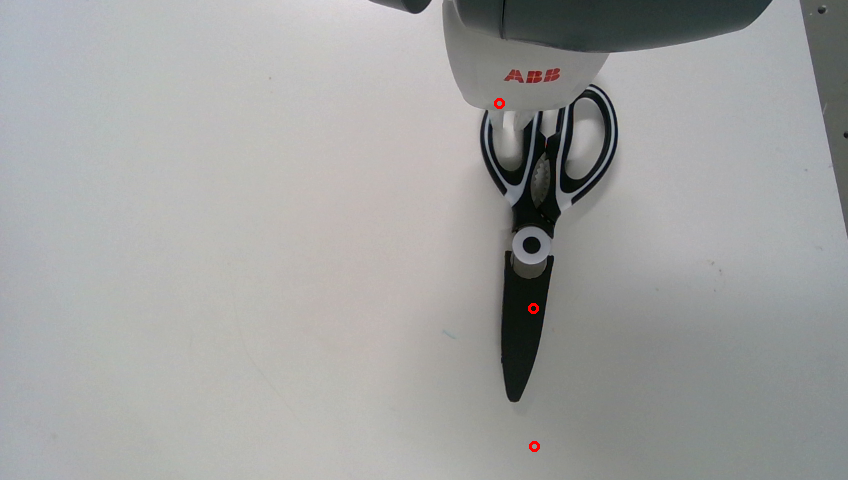

In [172]:
wrist_rgb = Image.open(f"experiments/{DIR}/live_right_in_view.png")

draw = ImageDraw.Draw(wrist_rgb)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
wrist_rgb

In [58]:
from PIL import Image, ImageDraw

head_rgb = Image.open(f"experiments/{DIR}/demo_head_rgb.png")

# Create a drawing context
draw = ImageDraw.Draw(head_rgb)

for point_2D in [[738, 466], [715, 635], [800, 910]]:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
head_rgb

NameError: name 'DIR' is not defined